# Bayesian statistics

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import uniform, binom, norm
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from tqdm import tqdm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def get_heads_prob(tosses):
    """
    Returns a posterior Beta(a + sum(x), b + sum(N) - sum(x))
    where a=1, b=1, sum(x)=num_heads and sum(N)=tosses
    """
    num_heads = np.sum(tosses)
    # prior: Beta(1, 1) ie uniform distribution
    return np.random.beta(1 + num_heads, 
                          1 + len(tosses) - num_heads, 
                          size=1_000)

We get handed a biased coin and we get asked to estimate the probability of tossing heads.

We cannot answer using common sense.

As a frequentist, we just cannot answer, we would need to count heads and trials.

As a Bayesian, we can at least say 'All probabilities between 0 and 1 have equal probability'.

Bayesians have prior beliefs. Frequentists do not.

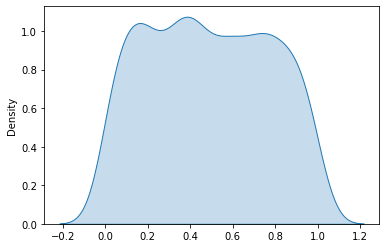

In [3]:
p_heads_distrib = get_heads_prob([])
sns.kdeplot(p_heads_distrib, shade=True)
plt.show()

We then get the opportunity to toss the coin once. We get tails.

As a frequentist, we would then conclude based on this one trial that the probability of tossing heads is 0% and no test would exist to give us confidence about this estimate, because the sample size is too small.

As a Bayesian, we would update our previous belief and say 'The probability of tossing heads is skewed to 0% but other probabilites are possible'.

Bayesians update their prior beliefs as they get more data. Frequentists do not.

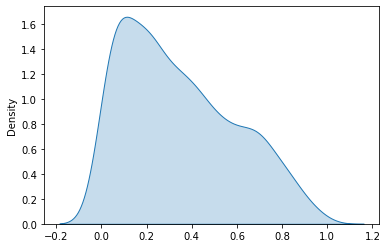

In [4]:
p_heads_distrib = get_heads_prob([0])
sns.kdeplot(p_heads_distrib, shade=True)
plt.show()

When we get sufficient data, both frequentists and Bayesians get to the same answer.

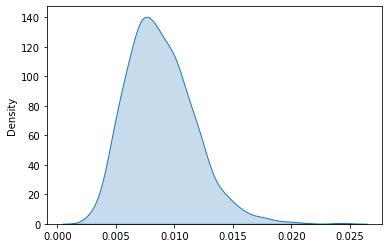

In [5]:
tosses = np.random.binomial(1, 0.005, 1_000)
p_heads_distrib = get_heads_prob(tosses)
sns.kdeplot(p_heads_distrib, shade=True)
plt.show()

## Bayesian estimation

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{P(X)}$$

$P(\theta|X)$ **posterior** distribution of the parameter we want to estimate

$P(X|\theta)$ **likelihood** (not the probability) of model parameters given the data

$P(\theta)$ **prior** distribution of model parameters when we haven't see any data yet (eg uniform distribution)

$P(X)$ scaling factor so posterior sums to 1 (when searching for the optimal $\theta$ this can be ignored)

#### Example

$\theta$ = a drug's efficacy rate (proportion of sick patients cured by the drug)

$X$ = number of cured patients

We're running a trial on 10 sick patients but while we're awaiting the results we can estimate the distributions of the drug's efficacy rate for every scenario.

In [6]:
num_patients_cured = np.arange(0, 11)
efficacy_rate = np.arange(0, 1.01, 0.01)
df = pd.DataFrame([(x, y) for x in num_patients_cured for y in efficacy_rate])
df.columns = ['num_patients_cured', 'efficacy_rate']

df['prior'] = uniform.pdf(df['efficacy_rate'])
df['likelihood'] = binom.pmf(df['num_patients_cured'], 10, df['efficacy_rate'])
df['posterior'] = df['prior'] * df['likelihood']
df['posterior_scaled'] = df.groupby('num_patients_cured')['posterior'].apply(lambda x: x/sum(x))

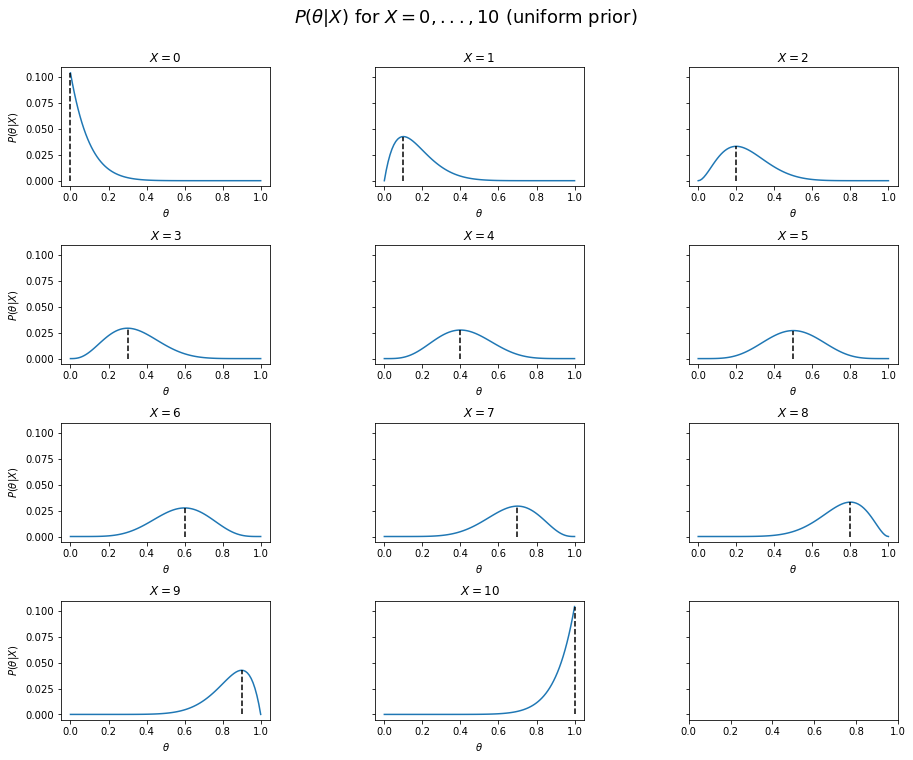

In [7]:
fig, axs = plt.subplots(4, 3, figsize=(15, 12), sharey=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle(r"$P(\theta|X)$ for $X=0,...,10$ (uniform prior)", fontsize=18, y=0.95)

for group, ax in zip(num_patients_cured, axs.ravel()):
    grouped = df[df['num_patients_cured'] == group]
    grouped.plot(x='efficacy_rate', y='posterior_scaled', xlabel=r'$\theta$', ylabel=r'$P(\theta|X)$', ax=ax)
    theta_best, posterior_best = grouped.sort_values('posterior_scaled', ascending=False).head(1)[['efficacy_rate', 'posterior_scaled']].values[0]
    ax.vlines(theta_best, ymin=0, ymax=posterior_best, colors='k', linestyles='dashed')
    ax.set_title(f"$X=${group}")
    ax.get_legend().remove()

plt.show()

If we observed 0 cured patients, the max posterior probability would be 10% when efficacy rate is 0%. Higher efficacy rates are exponentially less likely and the probability tails off after 20% efficacy rate.

The distributions are symmetrical, that is X=0 is the mirror of X=10, X=1 is the mirror of X=9 etc.

As we get to X=5 the peak of the distributions gets lower and the distributions fatter. This means that if we observed 5 cured patients, the max posterior probability would be 2.7% when efficacy rate is 50%, but efficacy rates around 50% are almost as likely, that is there is greater uncertainty about the efficacy rate when X=5.

In [8]:
best_posteriors = (df
 .sort_values('posterior', ascending=False)
 .groupby('num_patients_cured')
 .head(1)
 .sort_values('num_patients_cured')
 .reset_index(drop=True)
)
best_posteriors

,num_patients_cured,efficacy_rate,prior,likelihood,posterior,posterior_scaled
0,0,0.0,1.0,1.000000,1.000000,0.104175
1,1,0.1,1.0,0.387420,0.387420,0.042655
2,2,0.2,1.0,0.301990,0.301990,0.033219
3,3,0.3,1.0,0.266828,0.266828,0.029351
4,4,0.4,1.0,0.250823,0.250823,0.027590
5,5,0.5,1.0,0.246094,0.246094,0.027070
6,6,0.6,1.0,0.250823,0.250823,0.027590
7,7,0.7,1.0,0.266828,0.266828,0.029351
8,8,0.8,1.0,0.301990,0.301990,0.033219
9,9,0.9,1.0,0.387420,0.387420,0.042655


The table above is basically the result of Maximum Likelihood Estimation and Maximum A Posterior Estimation.

We've taken the value of $\theta$ that maximizes $P(\theta|X)$.

Since the prior is a uniform distribution (1.0 everywhere), MLE=MAP.

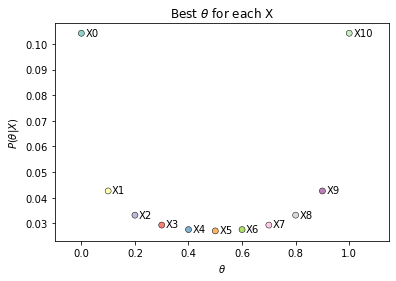

In [9]:
ax = sns.scatterplot(x='efficacy_rate', y='posterior_scaled', hue='num_patients_cured', data=best_posteriors, legend=False, palette="Set3", edgecolor='k')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta|X)$')
plt.title(r'Best $\theta$ for each X')

for i in range(11):
    ax.text(best_posteriors.loc[i, 'efficacy_rate']+0.015, best_posteriors.loc[i, 'posterior_scaled']-0.001, f"X{i}")

ax.set_xlim(left=-0.1, right=1.15)
plt.show()

Imagine we get 10 new more patients for a second trial after having observed 7 cured patients out of 10 in the first trial.

Before the first trial we didn't have any prior beliefs regarding the drug's efficacy, but now we do, so we can re-estimate the distributions of the efficacy rate for the second trial by updating our prior distribution.

In [10]:
num_patients_cured2 = np.arange(0, 11)
efficacy_rate2 = np.arange(0, 1.01, 0.01)
df2 = pd.DataFrame([(x, y) for x in num_patients_cured2 for y in efficacy_rate2])
df2.columns = ['num_patients_cured', 'efficacy_rate']

repeated_priors = []
for _ in range(11):
    repeated_priors.extend(df[df['num_patients_cured']==7]['posterior_scaled'].values)

df2['prior'] = repeated_priors
df2['likelihood'] = binom.pmf(df2['num_patients_cured'], 10, df2['efficacy_rate'])
df2['posterior'] = df2['prior'] * df2['likelihood']
df2['posterior_scaled'] = df2.groupby('num_patients_cured')['posterior'].apply(lambda x: x/sum(x))

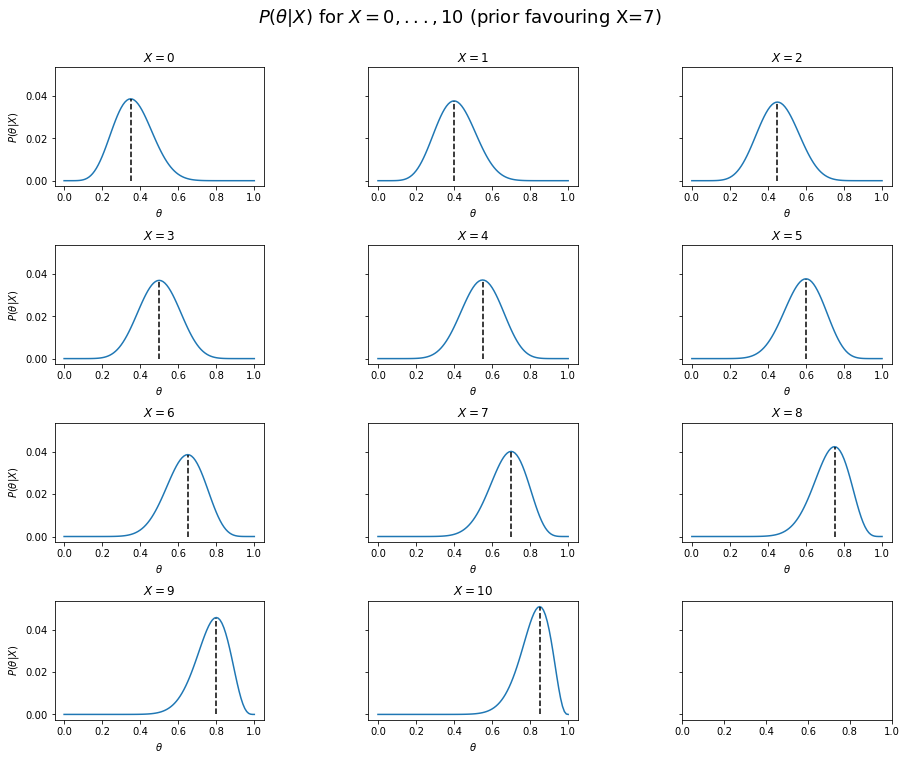

In [11]:
fig, axs = plt.subplots(4, 3, figsize=(15, 12), sharey=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle(r"$P(\theta|X)$ for $X=0,...,10$ (prior favouring X=7)", fontsize=18, y=0.95)

for group, ax in zip(num_patients_cured2, axs.ravel()):
    grouped = df2[df2['num_patients_cured'] == group]
    grouped.plot(x='efficacy_rate', y='posterior_scaled', xlabel=r'$\theta$', ylabel=r'$P(\theta|X)$', ax=ax)
    theta_best, posterior_best = grouped.sort_values('posterior_scaled', ascending=False).head(1)[['efficacy_rate', 'posterior_scaled']].values[0]
    ax.vlines(theta_best, ymin=0, ymax=posterior_best, colors='k', linestyles='dashed')
    ax.set_title(f"$X=${group}")
    ax.get_legend().remove()

plt.show()

With a prior favouring X=7, we see that X=6 is not peaking at 0.6, nor X=8 is peaking at 0.8 like when the prior was uniform. Now, everything is skewed towards 0.7.

And the posterior for 0.7 when X=7 has a higher peak (at 0.040 vs 0.029) and it has less uncertainty around this mean.

In [12]:
best_posteriors2 = (df2
 .sort_values('posterior', ascending=False)
 .groupby('num_patients_cured')
 .head(1)
 .sort_values('num_patients_cured')
 .reset_index(drop=True)
)
best_posteriors2

,num_patients_cured,efficacy_rate,prior,likelihood,posterior,posterior_scaled
0,0,0.35,0.002332,0.013463,0.000031,0.038724
1,1,0.40,0.004671,0.040311,0.000188,0.037738
2,2,0.45,0.008206,0.076303,0.000626,0.037182
3,3,0.50,0.012891,0.117188,0.001511,0.037001
4,4,0.55,0.018313,0.159568,0.002922,0.037182
5,5,0.60,0.023649,0.200658,0.004745,0.037738
6,6,0.65,0.027744,0.237668,0.006594,0.038724
7,7,0.70,0.029351,0.266828,0.007832,0.040244
8,8,0.75,0.027531,0.281568,0.007752,0.042490
9,9,0.80,0.022146,0.268435,0.005945,0.045822


There are the results of MAP on the new data.

Now, MLE and MAP give very different results because of the prior.

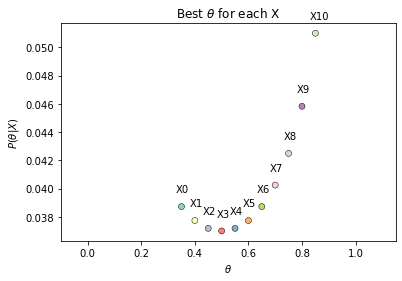

In [13]:
ax = sns.scatterplot(x='efficacy_rate', y='posterior_scaled', hue='num_patients_cured', data=best_posteriors2, legend=False, palette="Set3", edgecolor='k')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta|X)$')
plt.title(r'Best $\theta$ for each X')

for i in range(11):
    ax.text(best_posteriors2.loc[i, 'efficacy_rate']-0.02, best_posteriors2.loc[i, 'posterior_scaled']+0.001, f"X{i}")

ax.set_xlim(left=-0.1, right=1.15)
plt.show()

In the chart below, we can clearly the effect of the prior on the distribution of $\theta$ when X=7. Higher peak and less dispersion around the mean.

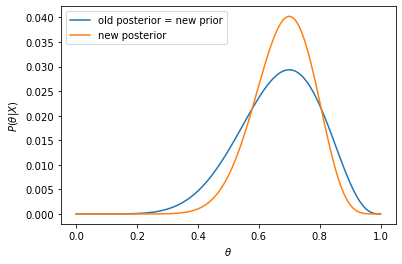

In [14]:
ax = df[df['num_patients_cured']==7].plot(x='efficacy_rate', y='posterior_scaled', label='old posterior = new prior')
df2[df2['num_patients_cured']==7].plot(x='efficacy_rate', y='posterior_scaled', xlabel=r'$\theta$', ylabel=r'$P(\theta|X)$', ax=ax, label='new posterior')
plt.show()

What's the effect of the prior if we got 100 patients in a trial?

In [15]:
num_patients_cured3 = np.arange(0, 101)
efficacy_rate3 = np.arange(0, 1.01, 0.01)
df3 = pd.DataFrame([(x, y) for x in num_patients_cured3 for y in efficacy_rate3])
df3.columns = ['num_patients_cured', 'efficacy_rate']

repeated_priors = []
for _ in range(101):
    repeated_priors.extend(df[df['num_patients_cured']==7]['posterior_scaled'].values)

df3['prior'] = repeated_priors
df3['likelihood'] = binom.pmf(df3['num_patients_cured'], 100, df3['efficacy_rate'])
df3['posterior'] = df3['prior'] * df3['likelihood']
df3['posterior_scaled'] = df3.groupby('num_patients_cured')['posterior'].apply(lambda x: x/sum(x))

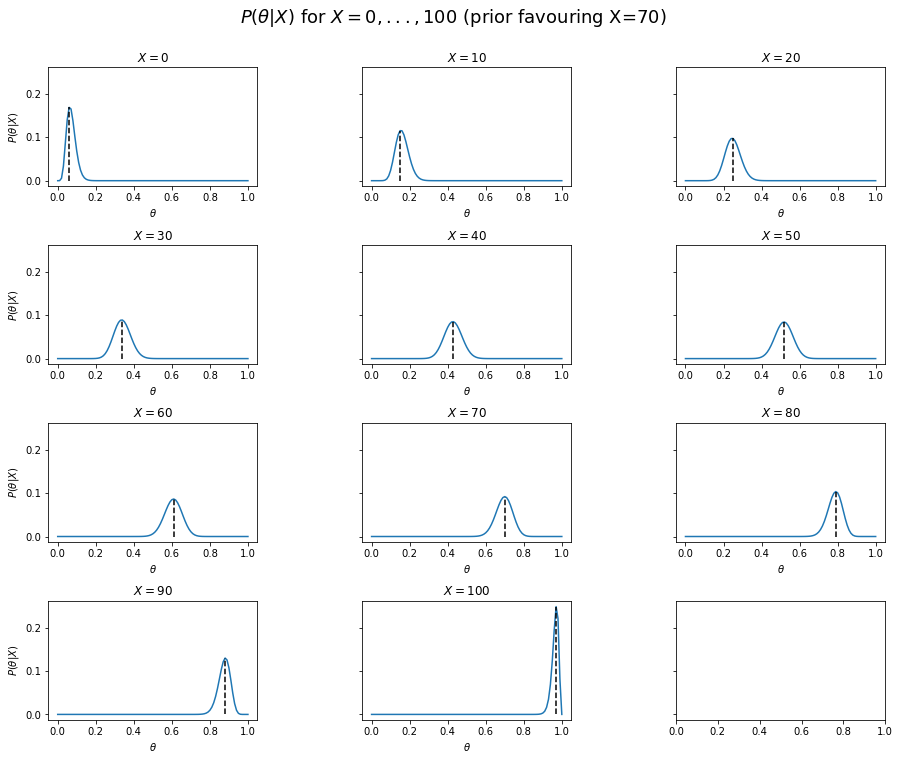

In [16]:
fig, axs = plt.subplots(4, 3, figsize=(15, 12), sharey=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle(r"$P(\theta|X)$ for $X=0,...,100$ (prior favouring X=70)", fontsize=18, y=0.95)

for group, ax in zip(num_patients_cured3[::10], axs.ravel()):
    grouped = df3[df3['num_patients_cured'] == group]
    grouped.plot(x='efficacy_rate', y='posterior_scaled', xlabel=r'$\theta$', ylabel=r'$P(\theta|X)$', ax=ax)
    theta_best, posterior_best = grouped.sort_values('posterior_scaled', ascending=False).head(1)[['efficacy_rate', 'posterior_scaled']].values[0]
    ax.vlines(theta_best, ymin=0, ymax=posterior_best, colors='k', linestyles='dashed')
    ax.set_title(f"$X=${group}")
    ax.get_legend().remove()

plt.show()

This now looks a lot like when we didn't have any prior. The efficacy rate when X=0 is close to 0%, when X=1 is close to 10% etc. The effect of the prior is still there, but it's milder.

In [17]:
best_posteriors3 = (df3
 .sort_values('posterior', ascending=False)
 .groupby('num_patients_cured')
 .head(1)
 .sort_values('num_patients_cured')
 .reset_index(drop=True)
 .iloc[::10,:]
)
best_posteriors3.round(3)

,num_patients_cured,efficacy_rate,prior,likelihood,posterior,posterior_scaled
0,0,0.06,0.000,0.002,0.000,0.169
10,10,0.15,0.000,0.044,0.000,0.115
20,20,0.25,0.000,0.049,0.000,0.097
30,30,0.34,0.002,0.060,0.000,0.089
40,40,0.43,0.007,0.068,0.000,0.085
50,50,0.52,0.015,0.073,0.001,0.084
60,60,0.61,0.025,0.080,0.002,0.086
70,70,0.70,0.029,0.087,0.003,0.092
80,80,0.79,0.023,0.096,0.002,0.103
90,90,0.88,0.009,0.108,0.001,0.130


The prior would always vote for 70% efficacy rate, but the likelihood would vote for the efficacy rate depending on the data, 10% when X=10, 20% when X=20 etc if the number of trials is 100.

When we don't have a lot of data, the likelihood is so uncertain about its vote, that it's more willing to accept what the prior has to say.

When we have a lot of data, the likelihood is more confident about its vote and it won't be as tolerant with the prior.

To see this power game in action between the prior and the likelihood, we can look at the data frame indices.

In [18]:
prior_vote = df3[df3['num_patients_cured']==30].sort_values('prior', ascending=False).head(1).round(3)
final_vote = df3[df3['num_patients_cured']==30].sort_values('posterior', ascending=False).head(1).round(3)
likelihood_vote = df3[df3['num_patients_cured']==30].sort_values('likelihood', ascending=False).head(1).round(3)
pd.concat([prior_vote, final_vote, likelihood_vote])

,num_patients_cured,efficacy_rate,prior,likelihood,posterior,posterior_scaled
3100,30,0.70,0.029,0.000,0.0,0.000
3064,30,0.34,0.002,0.060,0.0,0.089
3060,30,0.30,0.001,0.087,0.0,0.064


In [19]:
print("When the sample is big...")
print(f"The best prior was at position {prior_vote.index[0]} and the best likelihood was at position {likelihood_vote.index[0]}.\n" +
      f"They found agreement at position {final_vote.index[0]}.")
print("Prior ", "-"*(prior_vote.index[0]-final_vote.index[0]), "|", "-"*(final_vote.index[0]-likelihood_vote.index[0]), " Likelihood\n",
" "*(6+prior_vote.index[0]-final_vote.index[0]), "^\n",
" "*(6+prior_vote.index[0]-final_vote.index[0]-5), "Final vote", sep="")

When the sample is big...
The best prior was at position 3100 and the best likelihood was at position 3060.
They found agreement at position 3064.
Prior ------------------------------------|---- Likelihood
                                          ^
                                     Final vote


In [20]:
prior_vote = df2[df2['num_patients_cured']==3].sort_values('prior', ascending=False).head(1).round(3)
final_vote = df2[df2['num_patients_cured']==3].sort_values('posterior', ascending=False).head(1).round(3)
likelihood_vote = df2[df2['num_patients_cured']==3].sort_values('likelihood', ascending=False).head(1).round(3)
pd.concat([prior_vote, final_vote, likelihood_vote])

,num_patients_cured,efficacy_rate,prior,likelihood,posterior,posterior_scaled
373,3,0.7,0.029,0.009,0.000,0.006
353,3,0.5,0.013,0.117,0.002,0.037
333,3,0.3,0.001,0.267,0.000,0.006


In [21]:
print("When the sample is small...")
print(f"The best prior was at position {prior_vote.index[0]} and the best likelihood was at position {likelihood_vote.index[0]}.\n" +
      f"They found agreement at position {final_vote.index[0]}.")
print("Prior ", "-"*(prior_vote.index[0]-final_vote.index[0]), "|", "-"*(final_vote.index[0]-likelihood_vote.index[0]), " Likelihood\n",
" "*(6+prior_vote.index[0]-final_vote.index[0]), "^\n",
" "*(6+prior_vote.index[0]-final_vote.index[0]-5), "Final vote", sep="")

When the sample is small...
The best prior was at position 373 and the best likelihood was at position 333.
They found agreement at position 353.
Prior --------------------|-------------------- Likelihood
                          ^
                     Final vote


## Conjugate priors

Some prior distributions as they get multiplied with specific likelihoods yield know posteriors.

For example a **prior beta distribution** with parameters $\alpha$ and $\beta$ if multiplied by a **binomial likelihood** will yield a **beta posterior distribution** with parameters $\alpha + \displaystyle\sum_{n=1} ^{n} x_i$ and $\beta + \displaystyle\sum_{n=1} ^{n} N_i - \displaystyle\sum_{n=1} ^{n} x_i$

When that's the case, instead of sampling from the prior distribution and multiplying by the likelihood, we can directly sample from the known posterior distribution.

## A/B testing for a website

In [22]:
def simulate_click_rate(visits, beta_params):
    """
    Simulate a Beta(alpha + sum(x), beta + sum(N) - sum(x)) distribution
    where sum(x)=num_clicks and sum(N)=vists
    Parameters:
    ----------
    visits: 1d array-like of 0's and 1's (0=no click, 1=click)
    beta_params: tuple with two integers (alpha, beta)
    Returns:
    --------
    1d numpy array with 10,000 click rates
    """
    num_clicks = np.sum(visits)
    alpha, beta = beta_params
    return np.random.beta(alpha + num_clicks, 
                          beta + len(visits) - num_clicks, 
                          size=10_000)

In [23]:
A_results = [0, 1, 1, 0, 1, 1]
B_results = [1, 0, 0, 0, 0, 0]
print(f"Click rate for A: {np.mean(A_results):.0%}")
print(f"Click rate for b: {np.mean(B_results):.0%}")


Click rate for A: 67%
Click rate for b: 17%


The results seem pretty compelling that A is better than B, but the sample size is rather small to jump to any conclusions.

Let's incorporate some prior knowledge to compensate for the lack of data.

A typical CTR for a website is 15% altough it can vary between 5% and 30%.

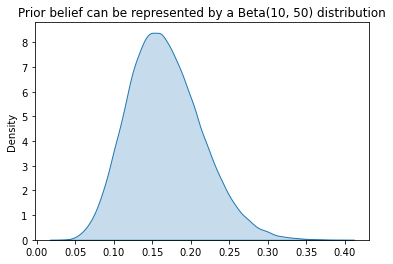

In [24]:
rng = np.random.default_rng(1)
prior = rng.beta(10, 50, 100_000)
sns.kdeplot(prior, shade=True)
plt.title("Prior belief can be represented by a Beta(10, 50) distribution")
plt.show()

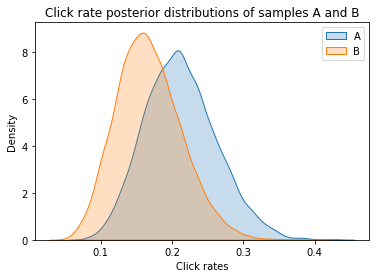

In [25]:
A_posterior = simulate_click_rate(A_results, beta_params=(10,50))
B_posterior = simulate_click_rate(B_results, beta_params=(10,50))

fig, ax = plt.subplots()
sns.kdeplot(A_posterior, shade=True, label='A')
sns.kdeplot(B_posterior, shade=True, label='B')
ax.legend()
plt.xlabel('Click rates')
plt.title('Click rate posterior distributions of samples A and B')
plt.show()

In [26]:
print(f"Click rate for A: {np.mean(A_posterior):.0%}")
print(f"Click rate for B: {np.mean(B_posterior):.0%}")

Click rate for A: 21%
Click rate for B: 17%


Our prior knowledge heavily skewed A towards 15%. It's almost like dismissing the results we got for A as outliers.

What was a very compelling picture in favour of A, now allows for more uncertainty that B might be better after all.

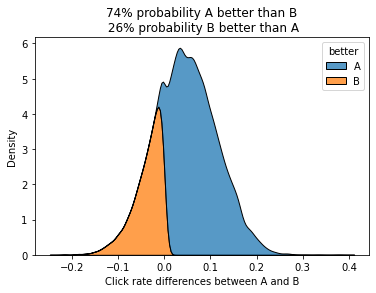

In [27]:
df = pd.DataFrame(A_posterior - B_posterior, columns=['diff'])
df['better'] = np.where(df['diff'] > 0, 'A', 'B')
sns.kdeplot(x='diff', hue='better', data=df, multiple='stack')
plt.xlabel("Click rate differences between A and B")
plt.title(f"{np.mean(A_posterior - B_posterior > 0):.0%} probability A better than B\n \
{np.mean(A_posterior - B_posterior < 0):.0%} probability B better than A")
plt.show()

## Simple linear regression on sales

## Linear regression on sales

We want to model sales as a function of marketing spending.

Prior knowledge:
- $5,000 sales without any marketing, but it could be $0 or even double
- $2,000 sales for any $1,000 in marketing spending, but more marketing could negatively impact sales or even have a greater positive impact (20:1 ratio)

**Model definition:**

$y = \beta_0 + \beta_1x_1$    

where $y \sim N(\beta_0 + \beta_1x_1, \sigma)$

and

$\beta_0 \sim N(5000, 2500)$

$\beta_1 \sim N(2, 10)$

$\sigma \sim U(0, 5)$

are how we define the priors.

**Method:**

Given:

$$P(\beta_0, \beta_1, \sigma|y, x_1) = \frac{P(y|x_1, \beta_0, \beta_1, \sigma)P(\beta_0, \beta_1, \sigma)}{P(y|x_1)}$$

where

$(\beta_0, \beta_1, \sigma|y, x_1)$ **posterior** distribution of the parameters we want to estimate

$P(y|x_1, \beta_0, \beta_1, \sigma)$ **likelihood** of the dependent variable given the parameters and the independent variable

$P(\beta_0, \beta_1, \sigma)$ **prior** distributions of the model parameters

$P(y|x_1)$ scaling factor so posterior sums to 1 (when searching for the optimal $\beta_0, \beta_1, sigma$ this can be ignored as it's a costant)

we need to find the best $\beta_0, \beta_1, \sigma$ that maximize $P(\beta_0, \beta_1, \sigma|y, x_1)$

so our optimization problem can be stated as

$\hat{\beta_0}, \hat{\beta_1}, \hat{\sigma}_{MAP} = \underset{\beta_0, \beta_1, \sigma}{\mathrm{argmax}} P(\beta_0, \beta_1, \sigma|y, x_1)$

We could use conjugate priors so that the posterior is known, but the conjugate priors might be not suitable or difficult to specify.

Grid approximation would be very inefficient.

The methods most used by far are Monte Carlo Markov Chain (MCMC) methods, which is a powerful combination of two methods: Monte Carlo and Markov Chains.

With MCMC we start sampling from a known distribution and eventually we reach a point where the samples approximate our target posterior distribution.

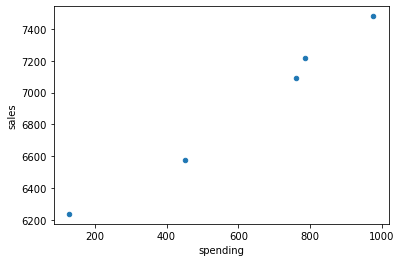

In [28]:
rng = np.random.default_rng(42)
e = rng.normal(0,50,5)
x = rng.uniform(0,1000,5)
y = 6000 + 1.5 * x + e
marketing = pd.DataFrame({
    'sales': y,
    'spending': x
})
_ = marketing.plot(x='spending', y='sales', kind='scatter')

In [29]:
%%time

# define parameters to evaluate
beta_0 = np.linspace(0, 10_000, 50)
beta_1 = np.linspace(0, 5, 50)
sd = np.linspace(1e-06, 10, 10)

# build parameters grid and replicate each combination for the number of x,y pairs
# we want to evaluate each parameter combination across all xi,yi
param_grid = pd.DataFrame(np.array(np.meshgrid(beta_0, beta_1, sd)).T.reshape(-1,3))
param_grid.columns = ['b0', 'b1', 'sd']
param_grid = pd.concat([param_grid for _ in range(len(marketing))])
param_grid.sort_values(['b0', 'b1', 'sd'], inplace=True)
param_grid.reset_index(drop=True, inplace=True)

# replicate xi,yi to fill up the parameters grid
data_grid = pd.concat([marketing for _ in range(len(param_grid) // len(marketing))])
data_grid.columns = ['y', 'x']
data_grid.reset_index(drop=True, inplace=True)

df = pd.concat([data_grid, param_grid], axis=1)

# there are as many sets as parameter combinations
# the size of each set is the amount of xi,yi
df['set'] = np.divmod(np.arange(len(df)),len(marketing))[0]

# calculate priors and likelihoods for each i
# using logpdf so can sum over i instead of prod over i
# maximizing -LL(x) is the same as maximizing p(x)
df['b0_prior'] = norm.logpdf(x=df['b0'], loc=5000, scale=2500)
df['b1_prior'] = norm.logpdf(x=df['b1'], loc=2, scale=10)
df['sd_prior'] = uniform.logpdf(x=df['sd'], loc=0, scale=5)
df['likelihood'] = norm.logpdf(x=df['y'], loc=df['b0'] + df['x']*df['b1'], scale=df['sd'])
df['posterior'] = df['b0_prior'] + df['b1_prior'] + df['sd_prior'] + df['likelihood']

# aggregate over all i's
df_agg = df.groupby('set').agg(
    {'b0':pd.Series.mode,
    'b1':pd.Series.mode,
    'sd':pd.Series.mode,
    'posterior':np.sum}
    ).copy()

# show best model
df_agg.sort_values('posterior', ascending=False).head(1)

CPU times: total: 29.9 s
Wall time: 30 s


,b0,b1,sd,posterior
set,,,,
14664,5918.367347,1.632653,4.444445,-702.038795


Below the results from using pymc3's MCMC implementation.

In [30]:
with pm.Model() as model:
    beta_0 = pm.Normal("b0", 5000, 2500)
    beta_1 = pm.Normal("b1", 2, 10)
    sigma = pm.Uniform("sd", 0, 5)
    likelihood = pm.Normal("y", mu=beta_0 + beta_1 * marketing.spending, sigma=sigma, observed=marketing.sales)
    trace = pm.sample(tune=10_000,
                      discard_tuned_samples=True,
                      draws=5_000,
                      return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, b1, b0]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 112 seconds.


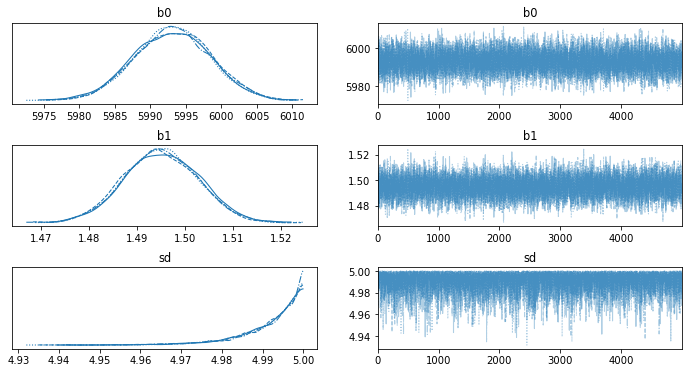

In [31]:
az.plot_trace(trace)
plt.subplots_adjust(hspace=0.5)

In [32]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,5993.095,5.339,5983.143,6003.11,0.062,0.044,7496.0,7489.0,1.0
b1,1.495,0.008,1.481,1.51,0.000,0.000,7245.0,8009.0,1.0
sd,4.992,0.008,4.977,5.00,0.000,0.000,7450.0,5809.0,1.0


pymc3's results are closer to the ground truth than the results from grid approximation.

Below is my own implementation of MCMC using Metropolis-Hastings algorithm.

1. set $\theta_{t-1} = 1$
2. draw $\theta^*$ from $N(\theta_{t-1}, \sigma)$ after choosing $\sigma$
3. compute $P(y,x|\theta_{t-1})P(\theta_{t-1})$ and $P(y,x|\theta^*)P(\theta^*)$
4. calculate $\alpha$ as $min(1, \frac{P(y,x|\theta^*)P(\theta^*)}{P(y,x|\theta_{t-1})P(\theta_{t-1})})$
5. draw $u$ from $U(0,1)$
6. if $u$ < $\alpha$ then $\theta^*$ is accepted as a sample and $\theta_{t+1}=\theta^*$
7. else $\theta_{t-1}$ is re-accepted as a sample and $\theta_{t+1}=\theta_{t-1}$

The optimal acceptance rate according to GO Roberts et al. (1997) is 23.4%.

The acceptance rate is very sensible to the $\sigma$ of the proposal distribution $N(\theta_{t-1}, \sigma)$.

I've found (empirically) that setting $\theta_{t-1}=min(x)$ and the proposal distributions' $\sigma$ to [10.0, 0.1, 0.1] for $\beta_0$, $\beta_1$ and $\sigma$ respectively (due to their respective scales) yield a decent acceptance rate and sensible-looking traces.

In [33]:
def f(data, c):
    """
    Compute numerator of posterior distribution
    
    Parameters
    ----------
    data: data frame with spending and sales
    c: dictionary with keys b0, b1 and sd and candidate values
    
    Returns
    -------
    numerator of posterior distribution in log-space
    """
    x, y = data['spending'].values, data['sales'].values
    posteriors = 0.0
    for xi, yi in zip(x, y):
        b0_prior = norm.logpdf(x=c['b0'], loc=5000, scale=2500)
        b1_prior = norm.logpdf(x=c['b1'], loc=2, scale=10)
        sd_prior = uniform.logpdf(x=c['sd'], loc=0, scale=5)
        likelihood = norm.logpdf(x=yi, loc=c['b0'] + xi*c['b1'], scale=c['sd'])
        posteriors += b0_prior + b1_prior + sd_prior + likelihood
    return posteriors

In [34]:
b0_samples = [marketing.sales.min()]
b1_samples = [0]
sd_samples = [1]
num_accept = 0
N = 30_000

for i in tqdm(range(N)):
    rng = np.random.default_rng(0+i)

    b0_candidate = rng.normal(b0_samples[-1], 10)
    b1_candidate = rng.normal(b1_samples[-1], 0.01)
    sd_candidate = rng.normal(sd_samples[-1], 0.01)

    candidate_likelihood = f(marketing, {'b0':b0_candidate, 'b1':b1_candidate, 'sd':sd_candidate})
    previous_likelihood = f(marketing, {'b0':b0_samples[-1], 'b1':b1_samples[-1], 'sd':sd_samples[-1]})
    alpha = min(np.log(1), candidate_likelihood - previous_likelihood)
    u = np.log(rng.random())

    if u < alpha:
        b0_samples.append(b0_candidate)
        b1_samples.append(b1_candidate)
        sd_samples.append(sd_candidate)
        num_accept += 1        
    else:
        b0_samples.append(b0_samples[-1])
        b1_samples.append(b1_samples[-1])
        sd_samples.append(sd_samples[-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [08:13<00:00, 60.78it/s]


In [35]:
print(f"Acceptance rate: {num_accept/N:.2%}")

Acceptance rate: 11.76%


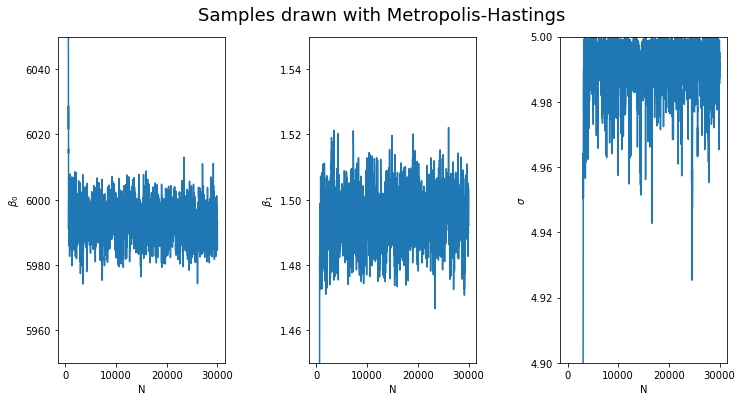

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5)
fig.suptitle("Samples drawn with Metropolis-Hastings", fontsize=18, y=0.95)

labels = [r'$\beta_0$', r'$\beta_1$', r'$\sigma$']
samples = [b0_samples, b1_samples, sd_samples]
# samples = [v for v in thetas.values()]
ylims = [[5950,6050], [1.45,1.55], [4.90,5.00]]

for s, l, b, ax in zip(samples, labels, ylims, axs.ravel()):
    ax.plot(s)
    ax.set_ylim(b)
    ax.set_xlabel("N")
    ax.set_ylabel(l)

plt.show()

In [37]:
burn_in = 5_000
b0_samples_valid = b0_samples[burn_in+1:]
b1_samples_valid = b1_samples[burn_in+1:]
sd_samples_valid = sd_samples[burn_in+1:]

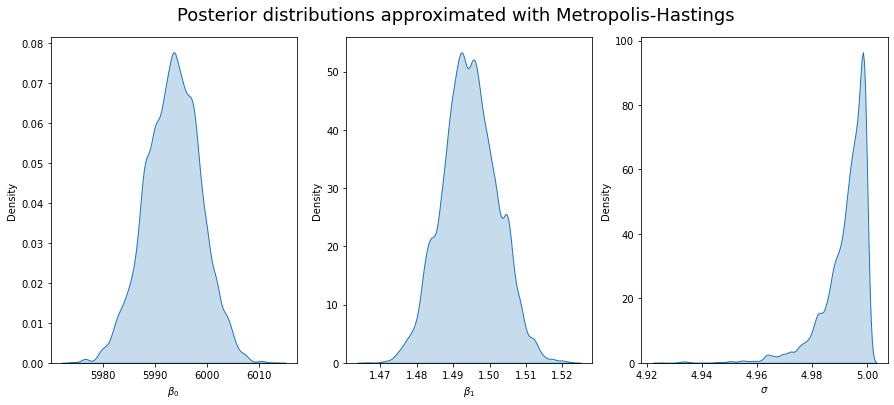

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle(r"Posterior distributions approximated with Metropolis-Hastings", fontsize=18, y=0.95)

labels = [r'$\beta_0$', r'$\beta_1$', r'$\sigma$']
samples = [b0_samples_valid, b1_samples_valid, sd_samples_valid]

for s, l, ax in zip(samples, labels, axs.ravel()):
    sns.kdeplot(s, shade=True, ax=ax)
    ax.set_xlabel(l)

plt.show()